In [27]:
#importing the relevant libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time
from pandas import DataFrame
from keras.utils import plot_model
from IPython.display import Image
from IPython.core.display import HTML 

# Recurrent Neural Networks

## Introduction

Recurrent Neural Networks are a type of neural networks with a feedback mechanism i.e. the ouput of a layer is added to the next input and fed back to same layer.
They solve the issue of maintaining sequential information in a neural netorks.
They are widely used in the prediction for stock price, sales, weather,etc.


[http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

 

In [28]:
Image(url = "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png")

### Type of Rnn Architecture 
__Methodolgy__
- Fully Recurrent Network
- Recursive Neural Networks
- Hopfield Networks
- Elman Networks and Jordan Networks
- Echo State Networks
- Neural history compressor
- **The Long Short-Term Memory Model (LSTM)**

__Input-Output Setting__
<img src=http://karpathy.github.io/assets/rnn/diags.jpeg width ="720"/>
[karpathy.github.io/2015/05/21/rnn-effectiveness](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)


However, they are faced with a lot of challenges. They are quite sensitive to changes in their paramters. Vanishing and Exploding gradients is major problem in these types of networks.

Hochreiter and Schmidhuber published a paper in 1997 to solve this problem by introducing __LSTM Long Short Term__ units.

### LSTM Architecture
Each LSTM has three gates which help to maintain the data 
- The "Input" or "Write" Gate handles the writing of the data

- The "output" or "Read" Gate sends the data back to the recurrent Network

- The "Forget" Gates is responsible for maintaing and storing data in each cell

[colah.github.io/posts/2015-08-Understanding-LSTMs](colah.github.io/posts/2015-08-Understanding-LSTMs)

In [29]:
Image(url = 'http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png')

## Business Case at CRL
### Stock Price Prediction of CRL listed at NYSE

- Efficient market Hypothesis 
[en.wikipedia.org/wiki/Efficient-market_hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis)

- Fundamental and Technical analyts argue that the we can make eductaed guessed about the stock market better than random chance. 


Stock Prices are affected by a phenomenon known as __autocorrelation__. A variety of other features and indexes do affect the stock prices.
In this study we are going to use percentage change in closing price values of NBI NASDAQ Biotechnology Index and CRL NYSE(Charles River Laboratories) Stock Index for predicting the future closing price of CRL NYSE stock price.
The __NASDAQ Biotechnology Index__ is a stock market index made up of securities of NASDAQ-listed companies classified according to the Industry Classification Benchmark as either Biotechnology or Pharmaceuticals.

### Step 1. Getting the Data 
__NBI__ and __CRL__ data from 01-04-2010 till 07-11-2017  has been pulled up from yahoo finances and stored locally in csv

In [13]:
#Reading the csv  file from local
crl = pd.read_csv("C:/Users/Shantam Gupta/Desktop/RNN/Data/crl.csv", index_col=False)

#Computing the price ratio as feature
crl['close_ratio'] = (crl['Close']/crl['Close'].shift(1) -1 ).fillna(0)

#Computing the Volume ratio as feature
crl['Vol_ratio'] = (crl['Volume']/crl['Volume'].shift(1) -1 ).fillna(0)

crl['crl_future_1'] = crl['Close'].shift(-1).fillna(0)

crl.head(),

(         Date       Open       High        Low      Close  Adj Close   Volume  \
 0  2010-01-04  33.740002  33.810001  33.259998  33.570000  33.570000  1000600   
 1  2010-01-05  33.599998  33.790001  33.349998  33.759998  33.759998   553200   
 2  2010-01-06  33.720001  33.770000  32.970001  33.310001  33.310001  1066900   
 3  2010-01-07  34.209999  34.650002  33.740002  34.619999  34.619999  1077300   
 4  2010-01-08  34.220001  35.080002  34.130001  34.389999  34.389999   982000   
 
    close_ratio  Vol_ratio  crl_future_1  
 0     0.000000   0.000000     33.759998  
 1     0.005660  -0.447132     33.310001  
 2    -0.013329   0.928597     34.619999  
 3     0.039327   0.009748     34.389999  
 4    -0.006644  -0.088462     34.740002  ,)

Reading the __NBI__ file and renaming the columns to avoid any naming conflicts with crl file

In [14]:
#Reading the csv file from local
nbi = pd.read_csv("C:/Users/Shantam Gupta/Desktop/RNN/Data/nbi.csv", index_col=False)

#Renaming the columns to avoid clash while joining crl and nbi later on 
nbi.columns = ['Date','nbi_open','nbi_high','nbi_low','nbi_close','nbi_adjclose','nbi_volume']

#Computing the price ratio difference as feature
nbi['nbi_close_ratio'] = (nbi['nbi_close']/nbi['nbi_close'].shift(1) -1 ).fillna(0)



nbi.head()

,Date,nbi_open,nbi_high,nbi_low,nbi_close,nbi_adjclose,nbi_volume,nbi_close_ratio
0,2010-01-04,851.830017,857.440002,851.380005,857.440002,857.440002,0,0.000000
1,2010-01-05,856.039978,856.979980,846.400024,851.250000,851.250000,0,-0.007219
2,2010-01-06,852.559998,859.710022,852.539978,857.669983,857.669983,0,0.007542
3,2010-01-07,856.869995,859.940002,851.630005,858.479980,858.479980,0,0.000944
4,2010-01-08,855.049988,863.489990,853.489990,863.270020,863.270020,0,0.005580


### Step 2: Preprocessing the Data
#### 2.1) Combining the two data frames crl and nbi 

In [15]:
df = pd.concat([crl,nbi],axis=1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_ratio,Vol_ratio,crl_future_1,Date,nbi_open,nbi_high,nbi_low,nbi_close,nbi_adjclose,nbi_volume,nbi_close_ratio
0,2010-01-04,33.740002,33.810001,33.259998,33.570000,33.570000,1000600,0.000000,0.000000,33.759998,2010-01-04,851.830017,857.440002,851.380005,857.440002,857.440002,0,0.000000
1,2010-01-05,33.599998,33.790001,33.349998,33.759998,33.759998,553200,0.005660,-0.447132,33.310001,2010-01-05,856.039978,856.979980,846.400024,851.250000,851.250000,0,-0.007219
2,2010-01-06,33.720001,33.770000,32.970001,33.310001,33.310001,1066900,-0.013329,0.928597,34.619999,2010-01-06,852.559998,859.710022,852.539978,857.669983,857.669983,0,0.007542
3,2010-01-07,34.209999,34.650002,33.740002,34.619999,34.619999,1077300,0.039327,0.009748,34.389999,2010-01-07,856.869995,859.940002,851.630005,858.479980,858.479980,0,0.000944
4,2010-01-08,34.220001,35.080002,34.130001,34.389999,34.389999,982000,-0.006644,-0.088462,34.740002,2010-01-08,855.049988,863.489990,853.489990,863.270020,863.270020,0,0.005580


Sorting the dataframe in ascending order

In [16]:
df.sort_index(ascending = True,inplace = True)

#### 2.2) Plotting and Exploration
Normalization is done for the two columns depicting the closing price of __CRL__ and __NBI__ to a feature range from 0 to 1. This normalization helps in plotting the two features on the same plot.

Ideally featutres are normailized before passsing into a Neural Network. This helps in faster convergence. 

We are using close raio and nbi_close_ratio as features in our network which are scaled within the range of 0 to 1 so we don't need to normalize them again

C:\Users\Shantam Gupta\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Shantam Gupta\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Shantam Gupta\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

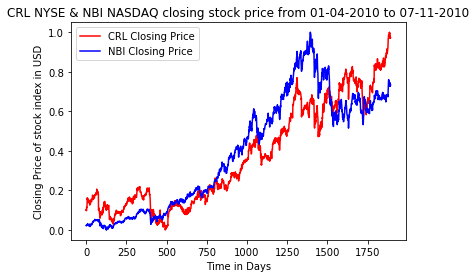

In [17]:
#normalizing closing prices and storing it in a new column
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))

df['close_norm'] = scaler1.fit_transform(df['Close'])
df['nbi_close_norm'] = scaler2.fit_transform(df['nbi_close'])
df['crl_future_norm_1'] = df['close_norm'].shift(-1)

#plottting the arrays
plt.plot(df['close_norm'],'-r',label = 'CRL Closing Price')
plt.plot(df['nbi_close_norm'],'-b',label = 'NBI Closing Price')
plt.title("CRL NYSE & NBI NASDAQ closing stock price from 01-04-2010 to 07-11-2010")
plt.xlabel("Time in Days")
plt.ylabel("Closing Price of stock index in USD")
plt.legend(loc='upper left')
plt.show()

In [18]:
#Checking Pearsons Correlation
#Presence of High Autocorrelation between crl close and crl_future(0.992)
np.corrcoef(df.Close,df.crl_future_1)

array([[ 1.        ,  0.99227025],
       [ 0.99227025,  1.        ]])

In [19]:
#Presence of High Correlation between nbi and crl_future(0.895)
np.corrcoef(df.nbi_close,df.crl_future_1)

array([[ 1.        ,  0.89546101],
       [ 0.89546101,  1.        ]])

In [20]:
#Presence of High Correlation between nbi and crl 0.899)
np.corrcoef(df.nbi_close,df.Close)

array([[ 1.       ,  0.8996143],
       [ 0.8996143,  1.       ]])

Presence of __high correlation__ between __CRL__ &  __NBI__ (amongst features) can pose a challenge. This lead to a higher challenge on selecting the right features for a Neural Network. 

### Step 3: Choosing an archcitecure for LSTM. 

We are using a many to one architecture for determing the future closing price CRL NYSE stock.

[machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/](http://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/)

### Step 4: Splitting into Test and Train Data

In [21]:
#taking 98% of the data points as train. This number can change.
train_size = int(0.98*len(df))

#segregating the inputs and ouput on the test and train data
trainX = df.loc[1:train_size,['close_norm','nbi_close_norm','Vol_ratio','nbi_close_ratio','close_ratio']]
trainY = df.loc[1:train_size,'crl_future_norm_1']
testX = df.loc[1856:1891,['close_norm','nbi_close_norm','Vol_ratio','nbi_close_ratio','close_ratio']]
testY = df.loc[1856:1891,'crl_future_norm_1']

In [22]:
#The inputs needed to be reshaped in the format of  a 3d Tensor with dimesnions = [batchsize,timesteps,features]
trainX = np.reshape(np.array(trainX),(trainX.shape[0],1,trainX.shape[1]))
testX= np.reshape(np.array(testX),(testX.shape[0],1,testX.shape[1]))

### Step 5: Designing the Architeure of the Network

Here we design the LSTM Layer architecture using keras and tensorflow as backend.

The model is __Sequential__ i.e. more than one layer is used in the architectcure.
The first layer has 50 LSTM units, The second one has 20. The input dimensions have to be specified for the first layer. Return_sequences is set to true determines whether to return the last output in the output sequence, or the full sequence.  Then we have added a linear dense activation for the final output.Also note that we have added dropout of 20% after the first layer to prevent overfitting on the train data.

The choice of optimizer is Adam i.e. __Adaptive Moment Estimation__.
[ruder.io/optimizing-gradient-descent/]([http://ruder.io/optimizing-gradient-descent/). 

We have selected __Mean Square Error__ as the loss function. We have taken a 10& validation split on train data to determine to optimize the hyperparamters in order to determine the best model


The hyperparamters and lstm unit layer configurations  are chosen after trying different combinations in the architecture. for more details refere : [keras.io/](https://keras.io/)

Note: There is internal shuffling between batches in keras which can be turned off if needed after training each batch.


In [23]:
model = Sequential()
model.add(LSTM(50 ,batch_input_shape=(1,trainX.shape[1],trainX.shape[2]),return_sequences = True))
model.add(Dropout(0.10))
model.add(LSTM(20))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam)
epochs = 50
start = time.time()
m = model.fit(trainX, np.array(trainY), epochs = epochs, batch_size=1, verbose=2,validation_split=0.1)
print ("Compilation Time : ", time.time() - start)

Train on 1669 samples, validate on 186 samples
Epoch 1/50
24s - loss: 0.0095 - val_loss: 0.0028
Epoch 2/50
11s - loss: 0.0011 - val_loss: 0.0028
Epoch 3/50
11s - loss: 9.0782e-04 - val_loss: 2.6318e-04
Epoch 4/50
11s - loss: 5.4834e-04 - val_loss: 9.5340e-04
Epoch 5/50
11s - loss: 4.6131e-04 - val_loss: 4.3336e-04
Epoch 6/50
12s - loss: 4.5235e-04 - val_loss: 5.7278e-04
Epoch 7/50
11s - loss: 4.5867e-04 - val_loss: 2.7248e-04
Epoch 8/50
12s - loss: 4.4871e-04 - val_loss: 4.1912e-04
Epoch 9/50
11s - loss: 3.7379e-04 - val_loss: 3.7893e-04
Epoch 10/50
11s - loss: 3.5196e-04 - val_loss: 3.1798e-04
Epoch 11/50
11s - loss: 4.3525e-04 - val_loss: 2.7865e-04
Epoch 12/50
11s - loss: 3.1940e-04 - val_loss: 6.7938e-04
Epoch 13/50
11s - loss: 3.5786e-04 - val_loss: 3.0528e-04
Epoch 14/50
11s - loss: 3.5367e-04 - val_loss: 3.1335e-04
Epoch 15/50
11s - loss: 3.8613e-04 - val_loss: 6.3964e-04
Epoch 16/50
11s - loss: 3.2631e-04 - val_loss: 3.8086e-04
Epoch 17/50
11s - loss: 3.5219e-04 - val_loss: 0.0

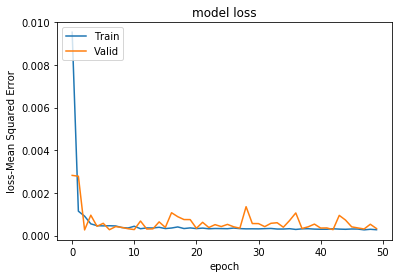

In [24]:
# summarize model for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss-Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

Increasing epochs after the first few observations doesn't reduce the train and validation losses. Thus a low dimensional epoch setting could work in this case or we can try a different architecture setting and explore.(It is diffuclt to guess whether the minima is local or global)

We might have  have to retrain and reduce the number of epochs while training to prevent overfititng on train.

### Step 6: Prediction on Test Data Points 

C:\Users\Shantam Gupta\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


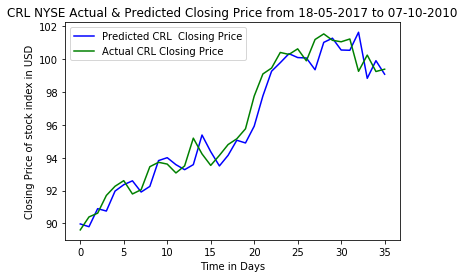

In [25]:
testPredict = model.predict(testX,batch_size = 1)
plt.plot(scaler1.inverse_transform(testPredict),'-b',label = 'Predicted CRL  Closing Price')
plt.plot(scaler1.inverse_transform(testY),'-g',label = 'Actual CRL Closing Price')
plt.title("CRL NYSE Actual & Predicted Closing Price from 18-05-2017 to 07-10-2010")
plt.xlabel("Time in Days")
plt.ylabel("Closing Price of stock index in USD")
plt.legend(loc='upper left')
plt.show()  

In [26]:
#transforming back the original predictions
scaler1.inverse_transform(testPredict)

array([[  89.96392822],
       [  89.7950058 ],
       [  90.8946228 ],
       [  90.74931335],
       [  91.96529388],
       [  92.35351562],
       [  92.59049988],
       [  91.90805817],
       [  92.25065613],
       [  93.82273865],
       [  94.00009155],
       [  93.57545471],
       [  93.26940918],
       [  93.5761795 ],
       [  95.38062286],
       [  94.36672974],
       [  93.49760437],
       [  94.14471436],
       [  95.06259918],
       [  94.89658356],
       [  95.91854095],
       [  97.76055908],
       [  99.26689911],
       [  99.78723145],
       [ 100.33530426],
       [ 100.09960938],
       [ 100.07330322],
       [  99.35740662],
       [ 101.02457428],
       [ 101.27753448],
       [ 100.55880737],
       [ 100.54257965],
       [ 101.64113617],
       [  98.83407593],
       [  99.90863037],
       [  99.08281708]], dtype=float32)

We can try out different architectures and configurations to optimize the task further!

### Reference Links
- [Machinelearningmastery blogs by Dr Jason Brownlee](http://machinelearningmastery.com/blog/)
- [Forecasting with Neural Networks](https://www.youtube.com/watch?v=lGaXq_Kgr2Y)
- [Long Short-Term Memory by Hochreiter & Schimdhuber](http://www.bioinf.jku.at/publications/older/2604.pdf)